In [113]:
from mphelper import ProcessWrapPool
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import itertools
from pathlib import Path
import pybedtools
import numpy as np
import seaborn as sns
import sys
from biodatatools.utils.common import json_load, json_dump
import os
import subprocess
import re
import mygene
import cairosvg
from scipy.cluster.hierarchy import linkage, leaves_list

In [3]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [4]:
sys.path.append(f"{Path.cwd().parent}")
import utils

In [5]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/softwares/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

# Homer motif enrichment: TRE vs. background

In [6]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [7]:
for p, d in itertools.product(ps, ds):
	outputfile = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}.bed"
	b = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	es = ["_".join(i.fields[:3]) for i in b]
	utils.generate_homer_input(es, outputfile)

In [8]:
# Use GC-matched background sequences generated by HOMER

pwpool = ProcessWrapPool(len(ps)*len(ds))

homer_dir = f"{PROJECT_DIR_s}homer/"
for d in ds:
	for p in ps:
		target = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}.bed"
		outdir = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}"
		pwpool.run(utils.run_homer, args=[homer_dir, target, outdir])

In [9]:
len(pwpool.finished_tasks)

4

In [10]:
pwpool.close()

In [8]:
# Write the content of all motifs in "knownResults.html"

outputfile = f"{PROJECT_DIR_o}tables/SuppTable2.xlsx"
with pd.ExcelWriter(outputfile, engine='openpyxl') as f:
	for d, p in itertools.product(ds, ps):
		html = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/knownResults.html"
		df = pd.read_html(html, header=0)[0]
		columns_keep = [c for c in df.columns if c not in ["Motif", "Motif File", "SVG"]]
		df = df[columns_keep]
		df.to_excel(f, sheet_name=f"{p}_{d}", index=False)

# Homer motif - gene name mapping

## ENCODE RNA-seq & ChIP-seq data

In [ ]:
# Here, we try to map motif names in Homer database to gene names used in K562 RNA-seq and ChIP-seq data from ENCODE portal for more strigent analysis or presentation

In [8]:
# RNA-seq data in K562

inputfile = f"{PROJECT_DIR_r}ENCODE/K562.ENCFF934YBO.TPM.txt"
df_exp = pd.read_table(inputfile, header=None)
df_exp.head(2)

,0,1
0,TSPAN6,0.03
1,TNMD,0.00


In [9]:
tpm = {}
for _, row in df_exp.iterrows():
	tpm[row[0]] = row[1]

In [10]:
acc_target = json_load(f"{PROJECT_DIR_r}ENCODE/acc_target.json")
acc_target_rev = defaultdict(list)
for acc in acc_target:
	acc_target_rev[acc_target[acc]].append(acc)

In [11]:
# Check if gene names used in K562 ChIP-seq data are the same as those in RNA-seq

[g for g in acc_target_rev if g not in tpm]

['POLR2AphosphoS2', 'POLR2AphosphoS5']

In [12]:
# Check if ChIP-seq target proteins have TPM > 1

[(g, tpm[g]) for g in acc_target_rev if g in tpm and tpm[g] <= 1]

[('ETS1', 0.14),
 ('ZBED1', 0.0),
 ('TCF7L2', 0.3),
 ('SMAD1', 0.25),
 ('ZBTB8A', 0.06),
 ('DACH1', 0.03),
 ('POU5F1', 0.0),
 ('NR2F1', 0.0),
 ('NEUROD1', 0.0),
 ('NR0B1', 0.0)]

## Motif name mapping

In [13]:
# To keep the high confidence set of motifs (also to lower the workload for mapping as some require manual inspection), only focus on motifs with P<1E-10 in at least one TRE category

motifs_sig = defaultdict(set)
motifs_sig_all = set()
dfs_known = {}
for p, d in itertools.product(ps, ds):
	dfs_known[(p,d)] = pd.read_table(f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/knownResults.txt")
	motifs_sig[(p,d)] = set(dfs_known[(p,d)][dfs_known[(p,d)]["P-value"]<1e-10]["Motif Name"])
	motifs_sig_all |= motifs_sig[(p,d)]

In [14]:
len(dfs_known[(p,d)]), len(motifs_sig_all)

(472, 134)

In [15]:
# http://homer.ucsd.edu/homer/motif/motifDatabase.html
# Promoter Motifs: Given the importance of the Transcription Start Site (TSS) and the fact that most transcription factors are found enriched in promoter regions, HOMER contains a library of motifs found by analyzing promoter regions vs. random genomic regions. 

[motif for motif in motifs_sig_all if "Promoter" in motif]

['TATA-Box(TBP)/Promoter/Homer',
 'NRF(NRF)/Promoter/Homer',
 'CRE(bZIP)/Promoter/Homer',
 'YY1(Zf)/Promoter/Homer',
 'GFX(?)/Promoter/Homer',
 'ETS(ETS)/Promoter/Homer',
 'E-box(bHLH)/Promoter/Homer',
 'GFY(?)/Promoter/Homer',
 'NFY(CCAAT)/Promoter/Homer',
 'Sp1(Zf)/Promoter/Homer',
 'GFY-Staf(?,Zf)/Promoter/Homer']

In [16]:
excluded = [
			# These are too general, we can't determine the specific gene to show for our purpose (and we'll include motifs with specific genes from the same family)
			# E-box: bHLH family, e.g., MYC, MYOD1, TCF3
			# CRE: bZIP family, e.g., CREB1, ATF, FOS
			# ETS: ETS family, et.g., ETS1, SPI1, ELK1
			'E-box(bHLH)/Promoter/Homer', 'CRE(bZIP)/Promoter/Homer', 'ETS(ETS)/Promoter/Homer',
			# General Factors X & Y (i.e. GFX & GFY): those motifs are 'unknown' in the sense that we do not know the principle factors that bind them; exclude this from our analyses
			'GFY(?)/Promoter/Homer', 'GFX(?)/Promoter/Homer'
		   ]

In [17]:
[motif for motif in motifs_sig_all if "Promoter" in motif and motif not in excluded]

['TATA-Box(TBP)/Promoter/Homer',
 'NRF(NRF)/Promoter/Homer',
 'YY1(Zf)/Promoter/Homer',
 'NFY(CCAAT)/Promoter/Homer',
 'Sp1(Zf)/Promoter/Homer',
 'GFY-Staf(?,Zf)/Promoter/Homer']

In [18]:
# 'GFY-Staf(?,Zf)/Promoter/Homer': ZNF143 is also known as STAF for Selenocysteyl tRNA Gene Transcription-Activating Factor; a critical promoter-binding TF involved in recruiting and stimulating RNA pol II at diverse promoters
# 'NFY(CCAAT)/Promoter/Homer': NF-Y is composed of three subunits: NF-YA, NF-YB, and NF-YC
# For promoter motifs in Homer database, we can keep these as they all expressed in K562

mapping = {}
for motif in motifs_sig_all:
	if "Promoter" in motif and motif not in excluded:
		if motif == 'GFY-Staf(?,Zf)/Promoter/Homer':
			gene = "ZNF143"
		elif motif == 'NFY(CCAAT)/Promoter/Homer':
			# NFYA & B & C are expressed; NFYA & B have ChIP-seq data available; NFYA contains the DNA-binding domain and provides sequence specificity
			gene = "NFYA"
		elif motif == 'NRF(NRF)/Promoter/Homer':
			gene = "NRF1"
		elif motif == 'TATA-Box(TBP)/Promoter/Homer':
			gene = "TBP"
		else:
			gene = motif.split("(")[0].upper()
		if gene in tpm:
			mapping[motif] = gene
		else:
			# No such case
			print(motif, gene)

In [19]:
# ChIP-Seq Transcription Factor Motifs: A vast majority of motifs in the HOMER motif database are based on the analysis of published ChIP-Seq data. Only high-quality ChIP-Seq experiments where the top HOMER motif resembled the consensus site for factors with the given DNA binding domain were used. Other motifs that are found, including strongly enriched composite motifs, were also included.
# Each motif in the database should contain information about the transcription factor name (e.g., PU.1), its DNA binding domain (e.g., ETS), its origin (e.g., ThioMac-PU.1-ChIP-Seq(GSE21512)), and the program/tool/resource used to generate it (e.g., Homer)

tf_motifs = [motif for motif in motifs_sig_all if "Promoter" not in motif]
mg = mygene.MyGeneInfo()
for motif in tf_motifs:
	if all(c not in motif.split("/")[0] for c in ":,-|+?") or "(T-box)" in motif.split("/")[0]:
		# The most common pattern: e.g., CTCF(Zf)/CD4+-CTCF-ChIP-Seq(Barski_et_al.)/Homer
		pattern1 = r'^([\w\.]+)\([^)]+\)/[^-]*-([\w\.]+)-'
		match1 = re.findall(pattern1, motif)
		if match1:
			tf = match1[0][0].upper()
			origin = match1[0][1].upper()
		else:
			# Only one case: Lhx6/Neurons-Lhx6-ChIP-seq(GSE85704)/Homer
			tf = motif.split("/")[0].upper()
			origin = motif.split("/")[1].split("-")[1].split(".")[0].upper()

		if tf == origin:
			# Motif - original ChIP - K562 ChIP/RNA-seq: same name
			if tf in tpm:
				mapping[motif] = tf
			# Get gene symbols
			else:
				if tf == "PU.1":
					gene = "SPI1"
				# Both STAT5A and STAT5B are expressed; STAT5A has ChIP-seq data available
				elif tf == "STAT5":
					gene = "STAT5A"
				elif tf == "ZFP281":
					gene = "ZNF281"
				else:
					result = mg.query(tf, fields="symbol", species="human")
					if tf == "FRA1":
						gene = result['hits'][1]['symbol']
					elif tf in ["NRF2", "SCL"]:
						gene = result['hits'][-1]['symbol']
					else:
						gene = result['hits'][0]['symbol']
					
				if gene in tpm:
					mapping[motif] = gene
				else:
					# No such case
					print(motif, gene)
						
		else:
			# ChIP-seq tags
			tags = [".Flag", ".iFlag", ".3xFlag",
					".GFP", ".eGFP",
					".HA", ".V5", ".biotin", ".Myc", ".Ty1"
				   ]
			match = False
			for tag in tags:
				if tf + tag.upper() == origin:
					match = True
					break
			if match:
				if tf in tpm:
					mapping[motif] = tf
				else:
					# No such case
					print(motif)
					
			else:
				if motif == "RUNX(Runt)/HPC7-Runx1-ChIP-Seq(GSE22178)/Homer":
					gene = "RUNX1"
				elif motif == "RFX(HTH)/K562-RFX3-ChIP-Seq(SRA012198)/Homer":
					gene = "RFX3"
				elif motif == "Fli1(ETS)/CD8-FLI-ChIP-Seq(GSE20898)/Homer":
					gene = "FLI1"
				else:
					result = mg.query(tf, fields="symbol", species="human")
					if tf == "AP4":
						tf2 = result['hits'][1]['symbol']
					else:
						tf2 = result['hits'][0]['symbol']
					if tf2 == origin:
						gene = tf2
					else:
						# print(motif)
						# Pknox1(Homeobox)/ES-Prep1-ChIP-Seq(GSE63282)/Homer
						# ISRE(IRF)/ThioMac-LPS-Expression(GSE23622)/Homer
						# Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer
						continue
			
				if gene in tpm:
					mapping[motif] = gene
				else:
					# No such case
					print(motif, gene)
				
	else:
		if motif == "Jun-AP1(bZIP)/K562-cJun-ChIP-Seq(GSE31477)/Homer":
			gene = "JUN"
		elif motif == "NF-E2(bZIP)/K562-NFE2-ChIP-Seq(GSE31477)/Homer":
			gene = "NFE2"
		elif motif == "c-Myc(bHLH)/LNCAP-cMyc-ChIP-Seq(Unpublished)/Homer":
			gene = "MYC"
		elif motif == "ZNF143|STAF(Zf)/CUTLL-ZNF143-ChIP-Seq(GSE29600)/Homer":
			gene = "ZNF143"
		# this ChIP-seq experiment was done on CD4⁺ T cells stimulated with IL-21
		elif motif == "Stat3+il21(Stat)/CD4-Stat3-ChIP-Seq(GSE19198)/Homer":
			gene = "STAT3"
		elif motif == "AR-halfsite(NR)/LNCaP-AR-ChIP-Seq(GSE27824)/Homer":
			gene = "AR"
		# Composite motifs
		elif motif == "ETS:RUNX(ETS,Runt)/Jurkat-RUNX1-ChIP-Seq(GSE17954)/Homer":
			gene = "RUNX1"
		elif motif == "PU.1:IRF8(ETS:IRF)/pDC-Irf8-ChIP-Seq(GSE66899)/Homer":
			gene = "IRF8"
		elif motif == "GATA:SCL(Zf,bHLH)/Ter119-SCL-ChIP-Seq(GSE18720)/Homer":
			gene = "TAL1"
		elif motif == "Fox:Ebox(Forkhead,bHLH)/Panc1-Foxa2-ChIP-Seq(GSE47459)/Homer":
			gene = "FOXA2"
		elif motif == "PU.1-IRF(ETS:IRF)/Bcell-PU.1-ChIP-Seq(GSE21512)/Homer":
			gene = "SPI1"
		else:
			# print(motif)
			# AP-1(bZIP)/ThioMac-PU.1-ChIP-Seq(GSE21512)/Homer
			# Ets1-distal(ETS)/CD4+-PolII-ChIP-Seq(Barski_et_al.)/Homer
			# The binding sites for EWS:FLI1 or EWS:ERG come from the ETS DNA-binding domain (FLI1 or ERG), not from EWSR1 itself.
			# EWS:ERG-fusion(ETS)/CADO_ES1-EWS:ERG-ChIP-Seq(SRA014231)/Homer
			# EWS:FLI1-fusion(ETS)/SK_N_MC-EWS:FLI1-ChIP-Seq(SRA014231)/Homer
			continue
			
		if gene in tpm:
			mapping[motif] = gene
		else:
			# No such case
			print(motif, gene)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [20]:
# For single motifs, we use the mapped gene name in the plot
# For composite motifs, we keep the motif name

mapping2 = {}
for motif in mapping:
	if motif in ["ETS:RUNX(ETS,Runt)/Jurkat-RUNX1-ChIP-Seq(GSE17954)/Homer",
				 "PU.1:IRF8(ETS:IRF)/pDC-Irf8-ChIP-Seq(GSE66899)/Homer",
				 "Stat3+il21(Stat)/CD4-Stat3-ChIP-Seq(GSE19198)/Homer",
				 "AR-halfsite(NR)/LNCaP-AR-ChIP-Seq(GSE27824)/Homer",
				 "Fox:Ebox(Forkhead,bHLH)/Panc1-Foxa2-ChIP-Seq(GSE47459)/Homer",
				 "PU.1-IRF(ETS:IRF)/Bcell-PU.1-ChIP-Seq(GSE21512)/Homer"
				]:
		mapping2[motif] = motif.split("(")[0]
	# TAL1 is more commonly used in human studies
	elif motif == "GATA:SCL(Zf,bHLH)/Ter119-SCL-ChIP-Seq(GSE18720)/Homer":
		mapping2[motif] = "GATA:TAL1"
	else:
		mapping2[motif] = mapping[motif]

In [21]:
# Removed: 5 promoter motifs, 7 TF motifs

len(motifs_sig_all), len(mapping)

(134, 122)

In [22]:
outputfile = f"{PROJECT_DIR_o}homer/homer_gene_name_mapping.json"
json_dump(outputfile, mapping)
outputfile = f"{PROJECT_DIR_o}homer/homer_motif_name_mapping.json"
json_dump(outputfile, mapping2)

In [23]:
results = []
for p, d in itertools.product(ps, ds):
	b = pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{p}_{d}.bed")
	results.append([len(b), len(motifs_sig[(p,d)]), len([motif for motif in motifs_sig[(p,d)] if motif in mapping])])
pd.DataFrame(results, columns=["No. elements", "No. sig motif types", "No. sig motif types with mapped names"], index=[f"{p.capitalize()} {d}" for p, d in itertools.product(ps, ds)])

,No. elements,No. sig motif types,No. sig motif types with mapped names
Divergent distal,8416,106,99
Divergent proximal,9026,103,92
Unidirectional distal,3557,75,69
Unidirectional proximal,1304,17,16


# Group motifs with high sequence similarity

In [24]:
# These are known motifs in Homer database; PWM is the same for a given motif in any category

pvalues = defaultdict(dict)
logos = {}
pwms = {}
for p, d in itertools.product(ps, ds):
	outdir = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/"
	for index, row in dfs_known[(p,d)].iterrows():
		if row["Motif Name"] in mapping:
			pvalues[(p,d)][row["Motif Name"]] = row["P-value"]
			svg_path = f"{outdir}knownResults/known{index+1}.logo.svg"
			png_path = f"{outdir}knownResults/known{index+1}.logo.png"
			if os.path.exists(svg_path) and row["Motif Name"] not in logos:
				cairosvg.svg2png(url=svg_path, write_to=png_path)
				logos[row["Motif Name"]] = png_path
				pwms[row["Motif Name"]] = f"{outdir}/knownResults/known{index+1}.motif"

In [25]:
def homer_to_meme(homer_files, output_meme):
    with open(output_meme, "w") as out:
        out.write("MEME version 4\n\n")
        out.write("ALPHABET= ACGT\n\n")
        out.write("strands: + -\n\n")
        out.write("Background letter frequencies:\n")
        out.write("A 0.25 C 0.25 G 0.25 T 0.25\n\n")

        for hf in homer_files:
            with open(hf) as f:
                lines = [l.strip() for l in f]

            header = lines[0]
            motif_name = header.split()[1]
            pwm_lines = lines[1:]

            pwm = []
            for line in pwm_lines:
                parts = line.split()
                if len(parts) != 4:
                    continue
                row = list(map(float, parts))
                total = sum(row)
                if total == 0:
                    row = [0.25, 0.25, 0.25, 0.25]
                else:
                    row = [v / total for v in row]
                pwm.append(row)

            pwm = np.array(pwm)
            width = pwm.shape[0]

            out.write(f"MOTIF {motif_name}\n")
            out.write("letter-probability matrix: ")
            out.write(f"alength= 4 w= {width}\n")

            for row in pwm:
                out.write(" ".join(f"{x:.6f}" for x in row) + "\n")

            out.write("\n")

In [26]:
# Convert HOMER .motif to MEME file as input for TOMTOM to calculate motif similarity

inputfiles = [pwms[motif] for motif in pwms]
outputfile = f"{PROJECT_DIR_o}homer/sig_motifs.meme"
homer_to_meme(inputfiles, outputfile)

In [27]:
# Group motifs with high sequence similarity

inputfile = f"{PROJECT_DIR_o}homer/sig_motifs.meme"
outdir = f"{PROJECT_DIR_o}homer/tomtom/"
commands = ["tomtom",
			"-dist pearson",
			"-thresh 1.0",
			"-min-overlap 5",
			# self-comparison of all motifs
			inputfile, inputfile,
			"-oc", outdir
		   ]
subprocess.run(" ".join(commands), shell=True)

The output directory '/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/tomtom/' already exists.
Its contents will be overwritten.
Processing query 1 out of 122 
# Computing q-values.
#   Estimating pi_0 from all 244 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.972073
#   Estimated pi_0=0.972073
Processing query 2 out of 122 
# Computing q-values.
#   Estimating pi_0 from all 244 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.976192
#   Estimated pi_0=0.976192
Processing query 3 out of 122 
# Computing q-values.
#   Estimating pi_0 from all 244 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.976192
#   Estimated pi_0=0.976192
Processing query 4 out of 122 
# Computing q-values.
#   Estimating pi_0 from all 244 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.976192
#   Estimated pi_0=0.976192
Processing query 5 out of 122 
# Computing q-values.
#   Estimating pi_0 from all 244 observed p-values.
#   Es

CompletedProcess(args='tomtom -dist pearson -thresh 1.0 -min-overlap 5 /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/sig_motifs.meme /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/sig_motifs.meme -oc /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/tomtom/', returncode=0)

In [28]:
df_tomtom = pd.read_table(f"{PROJECT_DIR_o}homer/tomtom/tomtom.tsv")
df_tomtom.head(2)

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,Gata1(Zf)/K562-GATA1-ChIP-Seq(GSE18829)/Homer,Gata1(Zf)/K562-GATA1-ChIP-Seq(GSE18829)/Homer,0.0,5.306240e-17,6.473620e-15,1.258570e-14,10.0,CAGATAAGGA,CAGATAAGGA,+
1,Gata1(Zf)/K562-GATA1-ChIP-Seq(GSE18829)/Homer,Gata2(Zf)/K562-GATA2-ChIP-Seq(GSE18829)/Homer,0.0,1.215730e-12,1.483190e-10,1.441770e-10,10.0,CAGATAAGGA,GAGATAAGGA,-


In [29]:
# Cluster motifs

sims = {}
for _, row in df_tomtom.iterrows():
	if "#" not in row["Query_ID"]:
		sims[(row["Query_ID"], row["Target_ID"])] = -np.log10(row["q-value"])
results = []
for motif1 in pwms:
	results.append([sims[(motif1,motif2)] for motif2 in pwms])
df_sim = pd.DataFrame(results, columns=list(pwms), index=list(pwms))

row_linkage = linkage(df_sim, method="ward", metric="euclidean")
row_order = leaves_list(row_linkage)
clustered_index = df_sim.index[row_order]
df_reordered = df_sim.loc[clustered_index, clustered_index]

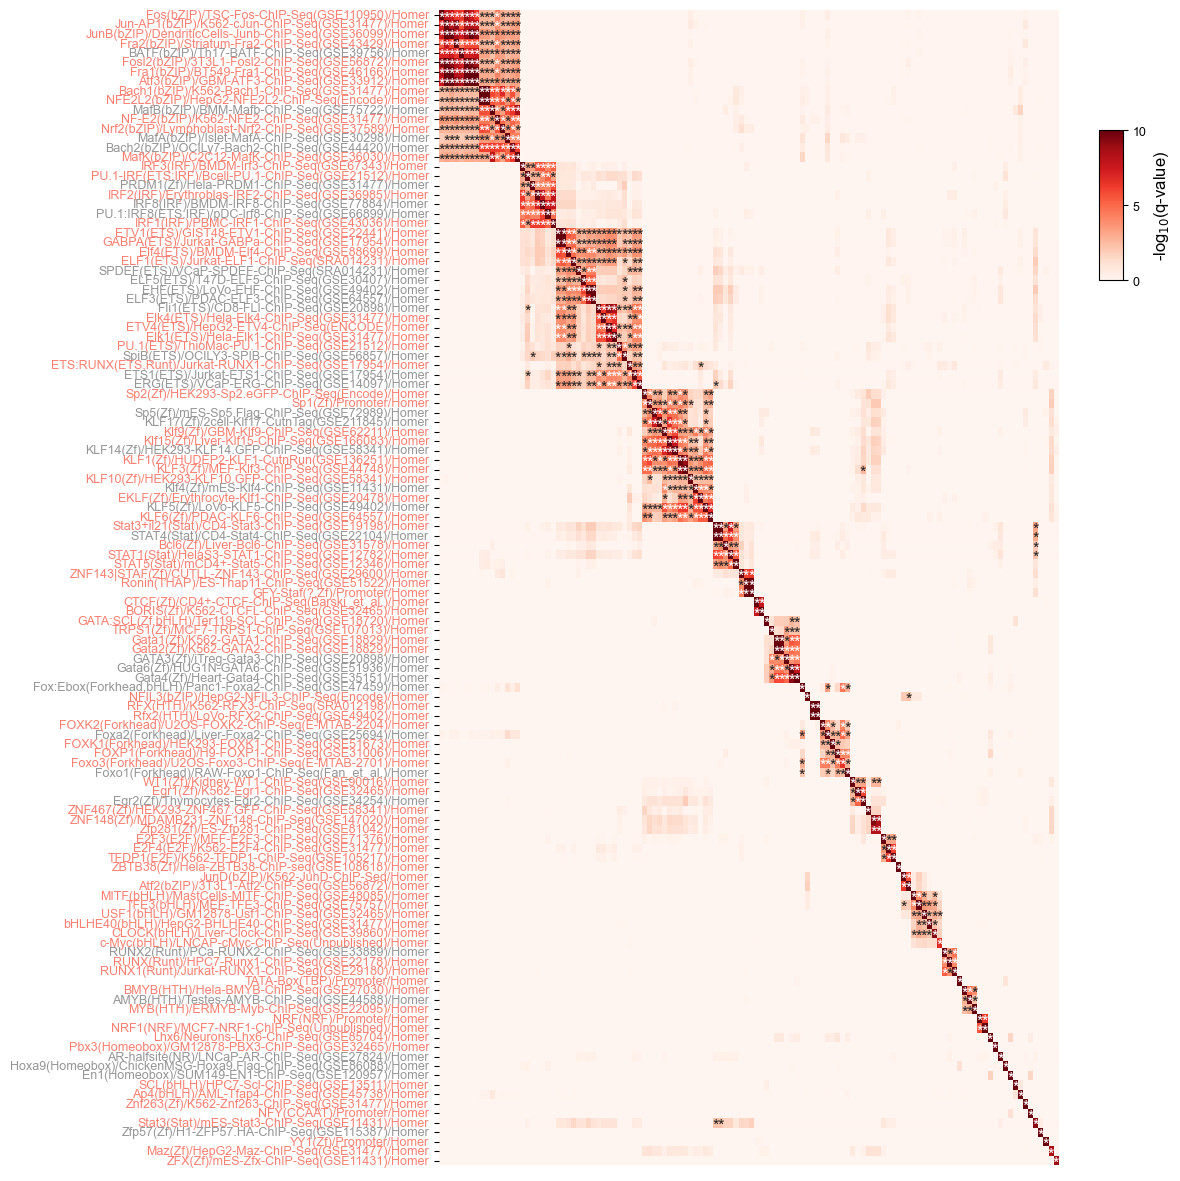

In [30]:
# Note that it's not symmetric because the null distribution (and hence the p-value) depends on the query motif's length and information content

fig, ax = plt.subplots(figsize=(8,15))
vlims = [0,5,10]
annot_matrix = df_reordered.apply(lambda col: col.map(lambda x: '*' if x > -np.log10(0.01) else ''))
g = sns.heatmap(df_reordered, vmin=vlims[0], vmax=vlims[2], cmap="Reds", 
				annot=annot_matrix, fmt='', annot_kws={"fontsize": bfontsize, "va": "center"},
                yticklabels=True, xticklabels=False, ax=ax, cbar=False)
for text in g.texts:
	if text.get_text() == "*":
		x, y = text.get_position()
		text.set_position((x, y+0.3))
		
for label in g.get_yticklabels():
	color = "#fb8072" if tpm[mapping[label.get_text()]] > 1 else "#969696"
	label.set_color(color)
	label.set_fontsize(sfontsize)
	
cbar_ax = fig.add_axes([0.95, 0.7, 0.03, 0.1])
sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=vlims[0], vmax=vlims[2]))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("-log$_{10}$(q-value)", fontsize=bfontsize)
cbar.set_ticks(vlims)
cbar.ax.tick_params(labelsize=sfontsize)

In [31]:
groups = {"Other AP-1": list(df_reordered.index[:8]),
		  "Other bZIP": list(df_reordered.index[8:16]),
		  "IRF": list(df_reordered.index[16:23]),
		  "ETS": list(df_reordered.index[23:40]),
		  "SP/KLF": list(df_reordered.index[40:54]),
		  "STAT/BCL6": list(df_reordered.index[54:59]) + ['Stat3(Stat)/mES-Stat3-ChIP-Seq(GSE11431)/Homer'],
          "ZNF143/THAP11": list(df_reordered.index[59:62]),
		  "CTCF/CTCFL": list(df_reordered.index[62:64]),
		  "GATA/TRPS1": list(df_reordered.index[65:71]),
		  "RFX": list(df_reordered.index[73:75]),
		  "FOX": list(df_reordered.index[75:81]),
		  "WT1/EGR": list(df_reordered.index[81:84]),
		  "ZNF148/ZNF281": list(df_reordered.index[85:87]),
		  "E2F": list(df_reordered.index[87:90]),
		  "JUND/ATF2": list(df_reordered.index[91:93]),
		  "Other bHLH": list(df_reordered.index[93:99]),
		  "RUNX": list(df_reordered.index[99:102]),
		  "MYB": list(df_reordered.index[103:106]),
		  "NRF": list(df_reordered.index[106:108])	 
		}

In [32]:
for motif in mapping:
	if motif not in [motif for group in groups for motif in groups[group]]:
		groups[mapping2[motif]] = [motif]

In [112]:
outputfile = f"{PROJECT_DIR_o}homer/homer_motif_groups.json"
json_dump(outputfile, groups)

In [33]:
def inspect_sequence_logos(motifs, group, logos):
	results = []
	for motif in motifs:
		results.append([group, motif, logos[motif]])
	
	fig, ax = plt.subplots(figsize=(8, len(motifs)*0.25))
	ax.axis('off')
		
	table_data = [[n, m, ""] for n, m, _ in results]
	table = ax.table(
		cellText=table_data,
		colLabels=["Family", "HOMER motif", "Logo"],
		cellLoc='center',
		loc='center',
		colWidths=[0.2, 0.7, 0.3]
	)
	table.auto_set_font_size(False)
	table.set_fontsize(sfontsize)
	
	for (row, col), cell in table.get_celld().items():
		text = cell.get_text()
		text.set_verticalalignment('center_baseline')
		if row > 0:
			text.set_y(-0.01)
			val = table.get_celld()[(row, 1)].get_text().get_text()
			color = "#fb8072" if tpm[mapping[val]] > 1 else "#969696"
			text.set_color(color)
	
	fig.canvas.draw_idle()
	
	for i, (_, _, img_path) in enumerate(results):
		img = mpimg.imread(img_path)
		imagebox = OffsetImage(img, zoom=0.15)
		cell = table[(i + 1, 2)]
		bbox = cell.get_window_extent(fig.canvas.get_renderer())
		(x0, y0), (x1, y1) = ax.transData.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
		x = (x0 + x1) / 2
		y = (y0 + y1) / 2
		ab = AnnotationBbox(imagebox, (x, y), frameon=False, box_alignment=(0.5, 0.5))
		ax.add_artist(ab)

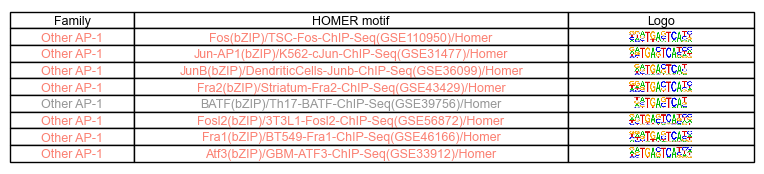

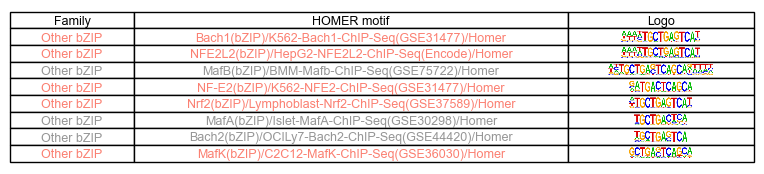

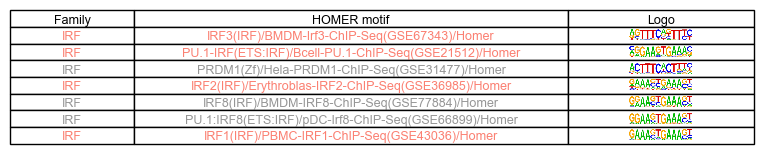

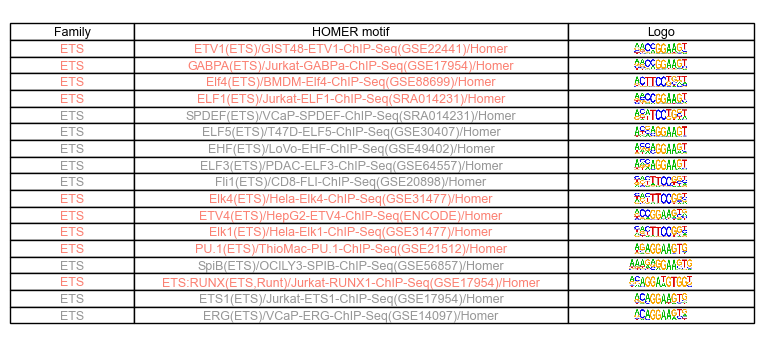

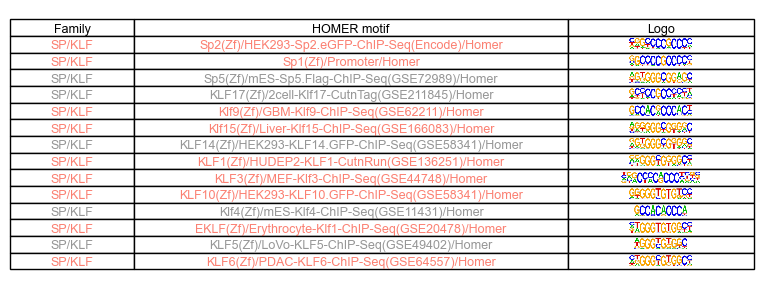

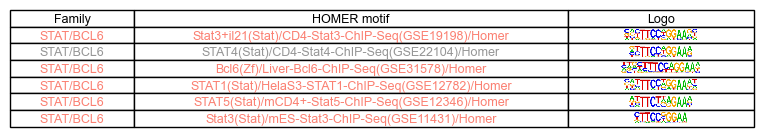

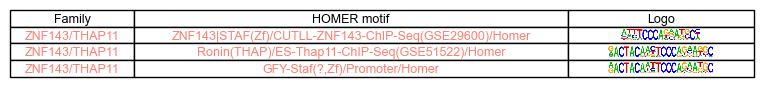

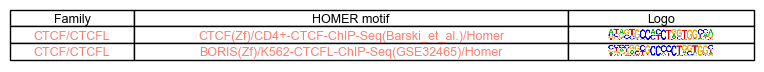

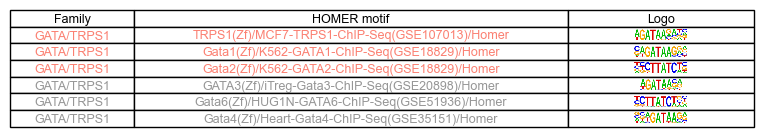

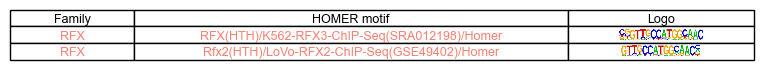

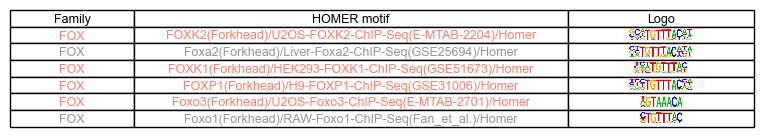

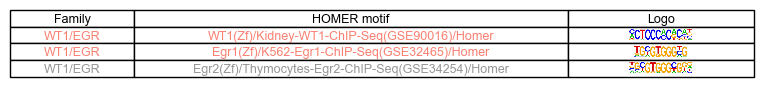

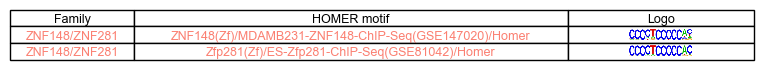

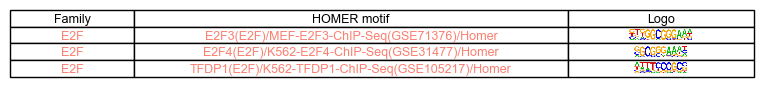

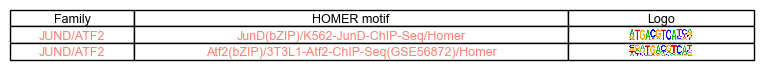

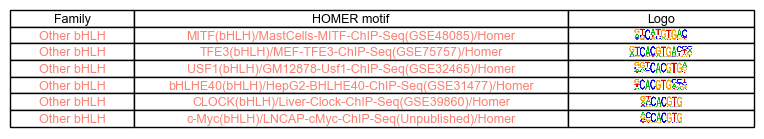

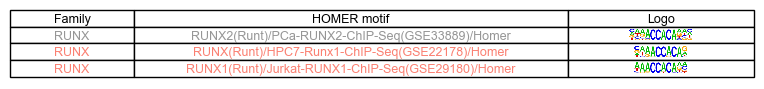

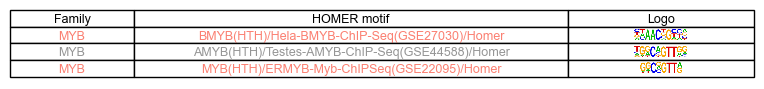

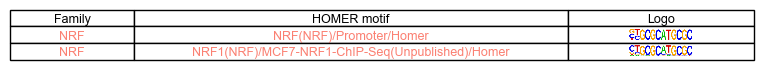

In [34]:
# Manually inspect all groups for confirmation

for group in groups:
	if len(groups[group]) > 1:
		inspect_sequence_logos(groups[group], group, logos)

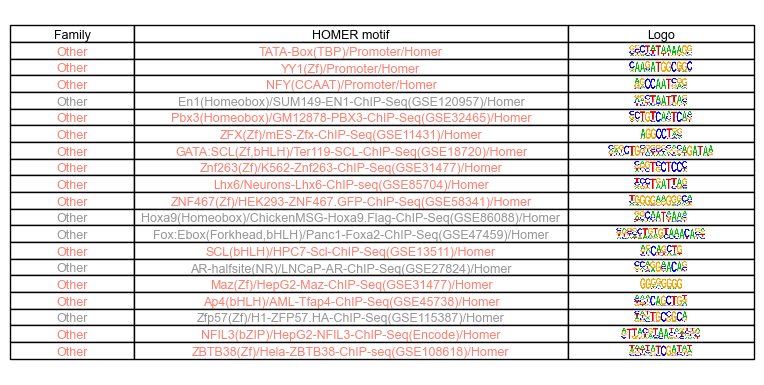

In [35]:
# Check the rest of motifs

inspect_sequence_logos([motif for group in groups if len(groups[group])==1 for motif in groups[group]], "Other", logos)

In [36]:
# For each TRE category, pick the motif with the most significant p-value for a given family; limited to motifs whose corresponding TF with TPM > 1 in K562.

motifs_selected = defaultdict(dict)
for group in groups:
	for p, d in itertools.product(ps, ds):
		df = dfs_known[(p,d)][dfs_known[(p,d)]["Motif Name"].isin(groups[group])].sort_values(by="Log P-value")
		keep = [motif for motif in list(df["Motif Name"]) if tpm[mapping[motif]]>1]
		if len(keep) > 0:
			motifs_selected[group][(p,d)] = keep[0]
len(motifs_selected)

33

# Motif enrichment plot

In [93]:
motifs_ordered = ["CTCF/CTCFL", "ZNF143/THAP11", 
				  "GATA:TAL1", "GATA/TRPS1", "TAL1",
				  "Other AP-1", "Other bZIP", 
				  "RFX", 'YY1', "NRF", "NFYA", "SP/KLF", "TBP"
				 ]
motifs_ordered.extend([motif for motif in motifs_selected if motif not in motifs_ordered])

In [106]:
ks = [f"{d.capitalize()} {p}" for d, p in itertools.product(ds, ps)]
results = []
for motif_type in motifs_ordered:
	row = []
	for d, p in itertools.product(ds, ps):
		df = dfs_known[(p,d)].set_index("Motif Name")
		df["% of Target Sequences with Motif"] = df["% of Target Sequences with Motif"].str.rstrip("%").astype(float)
		df["% of Background Sequences with Motif"] = df["% of Background Sequences with Motif"].str.rstrip("%").astype(float)
		df["FC"] = df["% of Target Sequences with Motif"]/df["% of Background Sequences with Motif"]
		motif = motifs_selected[motif_type][(p,d)]
		if df.loc[motif, "P-value"] < 1e-10:
			logp = -np.log10(1e-10)
		else:
			logp = -np.log10(df.loc[motif, "P-value"])
		logFC = np.log2(df.loc[motif, "FC"])
		
		row.append((logFC, logp))
	results.append(row)
df_enchr = pd.DataFrame(results, columns=ks, index=list(motifs_ordered))

In [91]:
vs = [df_enchr.values[row, col][0] for row in range(len(df_enchr.index)) for col in range(len(df_enchr.columns))]
np.min(vs), np.max(vs)

(-0.06495544184076985, 2.767440552506553)

In [ ]:
# Show distal elements in ExtDataFig and proximal elements in SuppFig

fig, ax = plt.subplots(figsize=(1.5, 8.5))
motifs = list(df_enchr.index)
ks = list(df_enchr.columns)[:2]

cmap = "Reds"
norm = mcolors.Normalize(vmin=0, vmax=2)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([1.25, 0.77, 0.08, 0.1])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=sfontsize)
cbar.set_label('log$_2$FC', fontsize=bfontsize)

sizes = [20, 40, 60, 80, 100]
labels = ['2', '4', '6', '8', '10']
for s, lab in zip(sizes, labels):
    ax.scatter([], [], s=s, c='k', alpha=0.6, edgecolors='none', label=lab)
size_legend = ax.legend(
    title='-log$_{10}$(p-value)',
	title_fontsize=bfontsize,
    loc='upper left',
	bbox_to_anchor=(1.1,0.82),
    scatterpoints=1,
    frameon=False
)

for i, motif in enumerate(motifs_ordered):
	for j, k in enumerate(ks):
		color, size = df_enchr.loc[motif, k]
		ax.scatter(j, i, c=color, s=size*10, cmap=cmap, edgecolors='black', norm=norm)

ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1])
ax.set_xticklabels([p.capitalize() for p in ps], rotation=30, ha='left', fontsize=bfontsize)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

ax.set_yticks(range(len(motifs_ordered)))
ax.set_yticklabels(motifs_ordered, fontsize=bfontsize)
ax.invert_yaxis()

ax.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig4a.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)

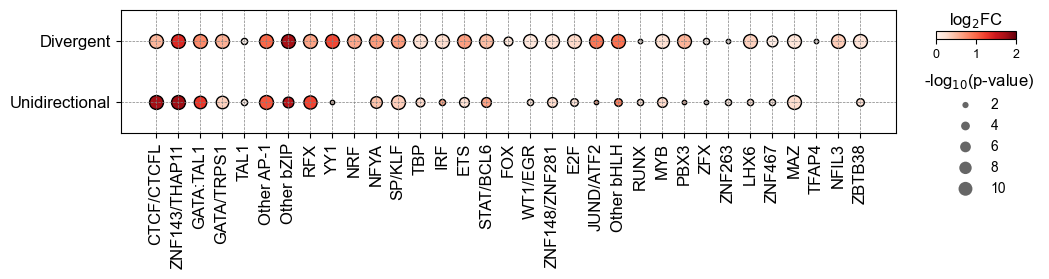

In [171]:
fig, ax = plt.subplots(figsize=(10,1.6))
motifs = list(df_enchr.index)
ks = list(df_enchr.columns)[2:]

cmap = "Reds"
norm = mcolors.Normalize(vmin=0, vmax=2)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.94, 0.7, 0.08, 0.05])
cbar = plt.colorbar(sm, orientation="horizontal", cax=cbar_ax)
cbar.ax.tick_params(labelsize=sfontsize)
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('log$_2$FC', fontsize=bfontsize)

sizes = [20, 40, 60, 80, 100]
labels = ['2', '4', '6', '8', '10']
for s, lab in zip(sizes, labels):
    ax.scatter([], [], s=s, c='k', alpha=0.6, edgecolors='none', label=lab)
size_legend = ax.legend(
    title='-log$_{10}$(p-value)',
	title_fontsize=bfontsize,
    loc='upper left',
	bbox_to_anchor=(1.02,0.6),
    scatterpoints=1,
    frameon=False
)

for i, motif in enumerate(motifs_ordered):
	for j, k in enumerate(ks):
		color, size = df_enchr.loc[motif, k]
		ax.scatter(i, j, c=color, s=size*10, cmap=cmap, edgecolors='black', norm=norm)

ax.set_ylim([-0.5,1.5])
ax.set_yticks([0,1])
ax.set_yticklabels([p.capitalize() for p in ps], fontsize=bfontsize)
ax.invert_yaxis()

ax.set_xticks(range(len(motifs_ordered)))
ax.set_xticklabels(motifs_ordered, fontsize=bfontsize, rotation=90)
for label in ax.get_xticklabels():
	label.set_horizontalalignment("center")

ax.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)
outputfile = f"{PROJECT_DIR_o}figures/SuppFig3a.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)